#   Q18 Machine Learning Rolling Basis

In this example we predict whether the price will rise or fall by using supervised learning (Bayesian Ridge Regression). This template represents a starting point for developing a system which can take part to the **Q18 NASDAQ-100 Stock Long-Short contest**.

It consists of two parts.

* In the **first part** we just perform a global training of the time series using all time series data. We disregard the sequential aspect of the data and use also future data to train past data.

* In the **second part** we use the built-in backtester and perform training and prediction on a rolling basis in order to avoid forward looking. Please note that we are using a **specialized** version of the Quantiacs backtester which dramatically speeds up the the backtesting process by retraining your model on a regular basis.

**Features for learning**: we will use several technical indicators trying to capture different features. You can have a look at [**Technical Indicators**](https://quantiacs.com/documentation/en/user_guide/technical_indicators.html).

Please note that:

* Your trading algorithm can open short and long positions.

* At each point in time your algorithm can trade all or a subset of the stocks which at that point of time are or were part of the NASDAQ-100 stock index. Note that the composition of this set changes in time, and Quantiacs provides you with an appropriate filter function for selecting them.

* The Sharpe ratio of your system since January 1st, 2006, has to be larger than 1.

* Your system cannot be a copy of the current examples. We run a correlation filter on the submissions and detect duplicates.

* For simplicity we will use a single asset. It pays off to use more assets, ideally uncorrelated, and diversify your positions for a more solid Sharpe ratio.

More details on the rules can be found [here](https://quantiacs.com/contest).

**Need help?** Check the [**Documentation**](https://quantiacs.com/documentation/en/) and find solutions/report problems in the [**Forum**](https://quantiacs.com/community/categories) section.

**More help with Jupyter?** Check the official [**Jupyter**](https://jupyter.org/) page.

Once you are done, click on **Submit to the contest** and take part to our competitions.

API reference:

* **data**: check how to work with [data](https://quantiacs.com/documentation/en/reference/data_load_functions.html);

* **backtesting**: read how to run the [simulation](https://quantiacs.com/documentation/en/reference/evaluation.html) and check the results.

Need to use the optimizer function to automate tedious tasks?

* **optimization**: read more on our [article](https://quantiacs.com/community/topic/29/optimizing-and-monitoring-a-trading-system-with-quantiacs).

In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) { return false; }
// disable widget scrolling

In [3]:
import logging

import xarray as xr  # xarray for data manipulation

import qnt.data as qndata     # functions for loading data
import qnt.backtester as qnbt # built-in backtester
import qnt.ta as qnta         # technical analysis library
import qnt.stats as qnstats   # statistical functions

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

np.seterr(divide = "ignore")

from qnt.ta.macd import macd
from qnt.ta.rsi  import rsi
from qnt.ta.stochastic import stochastic_k, stochastic, slow_stochastic

from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

In [8]:
# loading nasdaq-100 stock data

stock_data = qndata.stocks.load_spx_data(tail = 365 * 5, assets =["NYS:A", "NYS:AA", "NYS:AAP", "NYS:ABBV", "NYS:ABT", "NYS:ACN", "NYS:ADCT", "NYS:ADM", "NYS:ADNT", "NYS:AEE", "NYS:AES", "NYS:AET", "NYS:AFL", "NYS:AGN", "NYS:AIG", "NYS:AIV", "NYS:AIZ", "NYS:AJG", "NYS:AKS", "NYS:ALB", "NYS:ALK", "NYS:ALL", "NYS:ALLE", "NYS:AMCR"])
#These assets represent key sectors such as technology, healthcare, energy, manufacturing, and real estate. They offer a mix of stability,
#resilience in defensive markets, and growth opportunities in innovative industries like biotechnology and renewable energy, making them ideal for
#diversified algorithmic trading strategies.

fetched chunk 1/1 0s
Data loaded 0s


In [13]:
def get_features(data):
    """Builds the features used for learning:
       * a trend indicator;
       * the moving average convergence divergence;
       * a volatility measure;
       * the stochastic oscillator;
       * the relative strength index;
       * the logarithm of the closing price.
       These features can be modified and new ones can be added easily.
    """

    # trend:
    trend = qnta.roc(qnta.lwma(data.sel(field="close"), 60), 1)

    # moving average convergence  divergence (MACD):
    macd = qnta.macd(data.sel(field="close"))
    macd2_line, macd2_signal, macd2_hist = qnta.macd(data, 12, 26, 9)

    # volatility:
    volatility = qnta.tr(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"))
    volatility = volatility / data.sel(field="close")
    volatility = qnta.lwma(volatility, 14)

    # the stochastic oscillator:
    k, d = qnta.stochastic(data.sel(field="high"), data.sel(field="low"), data.sel(field="close"), 14)

    # the relative strength index:
    rsi = qnta.rsi(data.sel(field="close"))

    # the logarithm of the closing price:
    price = data.sel(field="close").ffill("time").bfill("time").fillna(0) # fill NaN
    price = np.log(price)

    #atr,The Average True Range (ATR) is useful in algorithmic trading as it measures market volatility. It helps in setting dynamic stop-loss levels,
    #position sizing, and identifying potential breakouts or trend reversals. Using ATR ensures strategies adapt to changing market conditions,
    #improving risk management and decision-making.
    vol = data.sel(field="vol")
    liq = data.sel(field="is_liquid")
    close = data.sel(field="close")
    high = data.sel(field="high")
    low = data.sel(field="low")
    atr = qnta.atr(high=high, low=low, close=close, ma=14)

    # combine the six features:
    result = xr.concat(
        [trend, macd2_signal.sel(field="close"), volatility,  d, rsi, price],
        pd.Index(
            ["trend",  "macd", "stochastic_d", "rsi", "price", "atr"],
            name = "field"
        )
    )

    return result.transpose("time", "field", "asset")

In [14]:
# displaying the features:
my_features = get_features(stock_data)
display(my_features.sel(field="trend").to_pandas())

asset,NYS:A,NYS:AA,NYS:AAP,NYS:ABBV,NYS:ABT,NYS:ACN,NYS:ADCT,NYS:ADM,NYS:ADNT,NYS:AEE,...,NYS:AIG,NYS:AIV,NYS:AIZ,NYS:AJG,NYS:AKS,NYS:ALB,NYS:ALK,NYS:ALL,NYS:ALLE,NYS:AMCR
time,,,,,,,,,,,,,,,,,,,,,
2020-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-03,-0.013385,NaN,NaN,-0.029282,-0.054107,-0.055942,NaN,-0.224170,NaN,-0.031512,...,-0.109578,NaN,0.042063,-0.120498,NaN,-0.388783,NaN,-0.052546,-0.254425,-0.338111
2025-01-06,0.008068,NaN,NaN,-0.046213,-0.076240,-0.078023,NaN,-0.243184,NaN,-0.104669,...,-0.123360,NaN,-0.027696,-0.163143,NaN,-0.303366,NaN,-0.147696,-0.274275,-0.297014
2025-01-07,0.035092,NaN,NaN,-0.052208,-0.064663,-0.029677,NaN,-0.248662,NaN,-0.065466,...,-0.115908,NaN,-0.042154,-0.122069,NaN,-0.304774,NaN,-0.146015,-0.308650,-0.266081


In [15]:
def get_target_classes(data):
    """ Target classes for predicting if price goes up or down."""

    price_current = data.sel(field="close")
    price_future  = qnta.shift(price_current, -1)

    class_positive = 1 # prices goes up
    class_negative = 0 # price goes down

    target_price_up = xr.where(price_future > price_current, class_positive, class_negative)

    return target_price_up

In [16]:
# displaying the target classes:
my_targetclass = get_target_classes(stock_data)
display(my_targetclass.to_pandas())

asset,NYS:A,NYS:AA,NYS:AAP,NYS:ABBV,NYS:ABT,NYS:ACN,NYS:ADCT,NYS:ADM,NYS:ADNT,NYS:AEE,...,NYS:AIG,NYS:AIV,NYS:AIZ,NYS:AJG,NYS:AKS,NYS:ALB,NYS:ALK,NYS:ALL,NYS:ALLE,NYS:AMCR
time,,,,,,,,,,,,,,,,,,,,,
2020-01-17,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
2020-01-21,1,0,0,0,1,1,0,0,0,0,...,1,0,0,1,0,1,0,0,1,1
2020-01-22,0,0,0,0,0,1,0,1,0,1,...,0,0,0,1,0,1,0,1,1,0
2020-01-23,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2020-01-24,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-03,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2025-01-06,1,0,0,0,1,1,0,0,0,1,...,1,0,0,1,0,0,0,1,0,1
2025-01-07,0,0,0,0,1,1,0,1,0,1,...,0,0,0,1,0,0,0,1,1,1


In [17]:
def get_model():
    """
The Ridge regression model is a solid choice because it addresses multicollinearity by adding an L2 regularization term, which prevents overfitting
and improves the model's generalization on datasets with highly correlated features.
    """

    model = linear_model.Ridge(alpha=.5)
    return model

In [18]:
# Create and train the models working on an asset-by-asset basis.

asset_name_all = stock_data.coords["asset"].values

models = dict()

for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = my_targetclass.sel(asset=asset_name).dropna("time", "any")
        features_cur = my_features.sel(asset=asset_name).dropna("time", "any")

        # align features and targets:
        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
            # not enough points for training
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

print(models)

{'NYS:A': Ridge(alpha=0.5), 'NYS:ABBV': Ridge(alpha=0.5), 'NYS:ABT': Ridge(alpha=0.5), 'NYS:ACN': Ridge(alpha=0.5), 'NYS:ADM': Ridge(alpha=0.5), 'NYS:AEE': Ridge(alpha=0.5), 'NYS:AES': Ridge(alpha=0.5), 'NYS:AFL': Ridge(alpha=0.5), 'NYS:AIG': Ridge(alpha=0.5), 'NYS:AIZ': Ridge(alpha=0.5), 'NYS:AJG': Ridge(alpha=0.5), 'NYS:ALB': Ridge(alpha=0.5), 'NYS:ALL': Ridge(alpha=0.5), 'NYS:ALLE': Ridge(alpha=0.5), 'NYS:AMCR': Ridge(alpha=0.5)}


/tmp/ipykernel_8869/1693025377.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/1693025377.py:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/1693025377.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/1693025377.py:11: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/1693025377.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dro

Feature: 0, Score: -0.13834
Feature: 1, Score: -0.00099
Feature: 2, Score: -0.08391
Feature: 3, Score: -0.00169
Feature: 4, Score: 0.00514
Feature: 5, Score: -0.27381


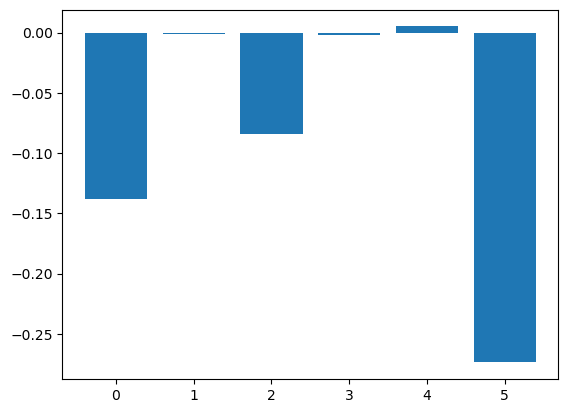

In [21]:
# Showing which features are more important in predicting:

importance = models["NYS:A"].coef_
importance

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [22]:
# Performs prediction and generates output weights:

asset_name_all = stock_data.coords["asset"].values
weights = xr.zeros_like(stock_data.sel(field="close"))

for asset_name in asset_name_all:
    if asset_name in models:
        model = models[asset_name]
        features_all = my_features
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")
        if len(features_cur.time) < 1:
            continue
        try:
            weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)
        except KeyboardInterrupt as e:
            raise e
        except:
            logging.exception("model prediction failed")

print(weights)

<xarray.DataArray 'stocks_s&p500' (time: 1253, asset: 24)> Size: 241kB
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.51798684, 0.        , 0.        , ..., 0.48773145, 0.46551383,
        0.52305241],
       [0.50392056, 0.        , 0.        , ..., 0.43150597, 0.47954446,
        0.51913286],
       [0.50253459, 0.        , 0.        , ..., 0.51176799, 0.47266561,
        0.55477434]])
Coordinates:
  * asset    (asset) <U8 768B 'NYS:A' 'NYS:AA' ... 'NYS:ALLE' 'NYS:AMCR'
  * time     (time) datetime64[ns] 10kB 2020-01-17 2020-01-21 ... 2025-01-10
    field    <U5 20B 'close'


/tmp/ipykernel_8869/2713452462.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/2713452462.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/2713452462.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/2713452462.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/2713452462.py:10: FutureWarning:

Passing 'how' as positional argument(s) to dro

In [23]:
def get_sharpe(stock_data, weights):
    """Calculates the Sharpe ratio"""
    rr = qnstats.calc_relative_return(stock_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(stock_data, weights)
sharpe

1.0196612147299955

The sharpe ratio using the method above follows from **forward looking**. Predictions for (let us say) 2017 know about the relation between features and targets in 2020. Let us visualize the results:

field,equity,relative_return,volatility,underwater,max_drawdown,sharpe_ratio,mean_return,bias,instruments,avg_turnover,avg_holding_time
time,,,,,,,,,,,
2025-01-03,2.259076,0.007634,0.169379,-0.069190,-0.148349,1.050592,0.177948,1.0,15.0,0.030012,74.636681
2025-01-06,2.242436,-0.007366,0.169350,-0.076047,-0.148349,1.039544,0.176047,1.0,15.0,0.030007,74.632176
2025-01-07,2.248502,0.002705,0.169285,-0.073548,-0.148349,1.042810,0.176532,1.0,15.0,0.030006,74.626217
2025-01-08,2.248057,-0.000198,0.169218,-0.073731,-0.148349,1.042045,0.176332,1.0,15.0,0.029998,74.631046
2025-01-10,2.214336,-0.015000,0.169296,-0.087625,-0.148349,1.019661,0.172624,1.0,15.0,0.030001,76.207392


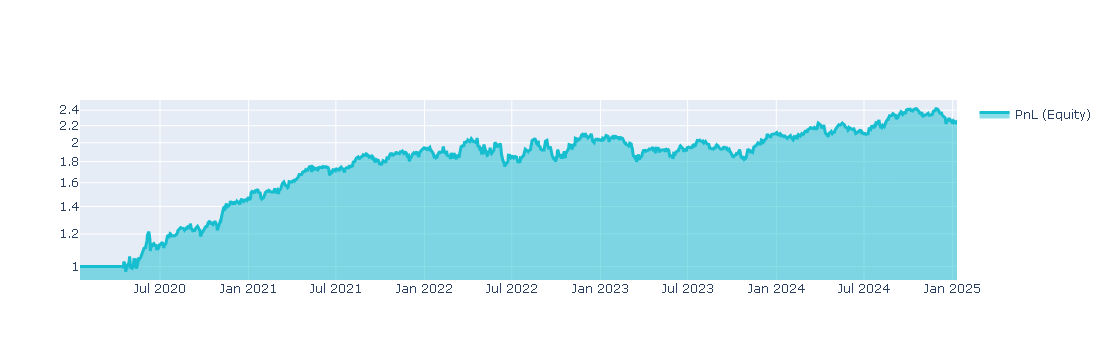

time,2025-01-10
field,
sharpe_ratio,1.019661



Ok. This strategy does not correlate with other strategies.


In [24]:
import qnt.graph as qngraph

statistics = qnstats.calc_stat(stock_data, weights)

display(statistics.to_pandas().tail())

performance = statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())

# check for correlations with existing strategies:
qnstats.print_correlation(weights,stock_data)

In [25]:
"""R2 (coefficient of determination) regression score function."""
r2_score(my_targetclass, weights, multioutput="variance_weighted")

-0.03442387593894957

In [26]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
explained_variance_score(my_targetclass, weights, multioutput="uniform_average")

0.3547250211633577

In [27]:
"""The explained variance score explains the dispersion of errors of a given dataset"""
mean_absolute_error(my_targetclass, weights)

0.3083831106352819

Let us now use the Quantiacs **backtester** for avoiding **forward looking**.

The backtester performs some transformations: it trains the model on one slice of data (using only data from the past) and predicts the weights for the following slice on a rolling basis:

In [28]:
def train_model(data):
    """Create and train the model working on an asset-by-asset basis."""

    asset_name_all = data.coords["asset"].values
    features_all   = get_features(data)
    target_all     = get_target_classes(data)

    models = dict()

    for asset_name in asset_name_all:

        # drop missing values:
        target_cur   = target_all.sel(asset=asset_name).dropna("time", "any")
        features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

        target_for_learn_df, feature_for_learn_df = xr.align(target_cur, features_cur, join="inner")

        if len(features_cur.time) < 10:
                continue

        model = get_model()

        try:
            model.fit(feature_for_learn_df.values, target_for_learn_df)
            models[asset_name] = model

        except:
            logging.exception("model training failed")

    return models

In [29]:
def predict_weights(models, data):
    """The model predicts if the price is going up or down.
       The prediction is performed for several days in order to speed up the evaluation."""

    asset_name_all = data.coords["asset"].values
    weights = xr.zeros_like(data.sel(field="close"))

    for asset_name in asset_name_all:
        if asset_name in models:
            model = models[asset_name]
            features_all = get_features(data)
            features_cur = features_all.sel(asset=asset_name).dropna("time", "any")

            if len(features_cur.time) < 1:
                continue

            try:
                weights.loc[dict(asset=asset_name, time=features_cur.time.values)] = model.predict(features_cur.values)

            except KeyboardInterrupt as e:
                raise e

            except:
                logging.exception("model prediction failed")

    return weights

In [30]:
# Calculate weights using the backtester:
weights = qnbt.backtest_ml(
    train                         = train_model,
    predict                       = predict_weights,
    train_period                  =  2 *365,  # the data length for training in calendar days
    retrain_interval              = 10 *365,  # how often we have to retrain models (calendar days)
    retrain_interval_after_submit = 1,        # how often retrain models after submission during evaluation (calendar days)
    predict_each_day              = False,    # Is it necessary to call prediction for every day during backtesting?
                                              # Set it to True if you suspect that get_features is looking forward.
    competition_type              = "stocks_nasdaq100",  # competition type
    lookback_period               = 365,                 # how many calendar days are needed by the predict function to generate the output
    start_date                    = "2005-01-01",        # backtest start date
    analyze                       = True,
    build_plots                   = True  # do you need the chart?
)

Run the last iteration...


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (8948288 of 8948288) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 4s
Data loaded 4s


/tmp/ipykernel_8869/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/926670739.py:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/926670739.py:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna w

fetched chunk 1/1 2s
Data loaded 2s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Run First Iteration...


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (9037908 of 9037908) |##############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/1 2s
Data loaded 2s


/tmp/ipykernel_8869/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/926670739.py:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/926670739.py:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna w

---
Run all iterations...
Load data...


/tmp/ipykernel_8869/3005845302.py:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/3005845302.py:12: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (13009496 of 13009496) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/8 1s


100% (13009496 of 13009496) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/8 2s


100% (13009496 of 13009496) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/8 5s


100% (13009472 of 13009472) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/8 6s


100% (13009404 of 13009404) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/8 7s


100% (13009404 of 13009404) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/8 7s


100% (13009404 of 13009404) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/8 8s


100% (13009472 of 13009472) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 8/8 9s
Data loaded 9s


100% (44115 of 44115) |##################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (12921088 of 12921088) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 1/7 1s


100% (12921084 of 12921084) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/7 2s


100% (12921084 of 12921084) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/7 4s


100% (12921060 of 12921060) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/7 7s


100% (12920980 of 12920980) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/7 9s


100% (12920980 of 12920980) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/7 10s


100% (12921060 of 12921060) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/7 11s
Data loaded 12s
Backtest...


/tmp/ipykernel_8869/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/926670739.py:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/926670739.py:14: FutureWarning:

Passing 'how' as positional argument(s) to dropna was deprecated in version v2023.10.0 and will raise an error two releases later. Please pass them as keyword arguments.

/tmp/ipykernel_8869/926670739.py:13: FutureWarning:

Passing 'how' as positional argument(s) to dropna w

fetched chunk 1/7 1s


100% (13023644 of 13023644) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 2/7 2s


100% (13023644 of 13023644) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 3/7 3s


100% (13023620 of 13023620) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 4/7 4s


100% (13023540 of 13023540) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 5/7 5s


100% (13023540 of 13023540) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 6/7 6s


100% (13023620 of 13023620) |############| Elapsed Time: 0:00:00 Time:  0:00:00


fetched chunk 7/7 7s
Data loaded 7s
Output cleaning...
fix uniq
ffill if the current price is None...
Check liquidity...
WARNING! Strategy trades non-liquid assets.
Fix liquidity...
Ok.
Check missed dates...
Ok.
Normalization...
Output cleaning is complete.
Write output: /root/fractions.nc.gz
State saved.
---
Analyze results...
Check...
Check liquidity...
Ok.
Check missed dates...
Ok.
Check the sharpe ratio...
Period: 2006-01-01 - 2025-01-10
Sharpe Ratio = 0.8582321615714902
Ok.
---
Align...
Calc global stats...
---
Calc stats per asset...
Build plots...
---
Select the asset (or leave blank to display the overall stats):


interactive(children=(Combobox(value='', description='asset', options=('', 'NAS:AAL', 'NAS:AAPL', 'NAS:ABNB', …

100% (5039 of 5039) |####################| Elapsed Time: 0:03:48 Time:  0:03:48


The Sharpe ratio is obviously smaller as the training process is not looking forward (as it happens by processing data on a global basis), but performed on a rolling basis.

# May I import libraries?

Yes, please refer to the file **init.ipynb** in your home directory. You can for example use:

! conda install -y scikit-learn

# How to load data?

Daily stock data for the **Q18 Nasdaq-100** contest can be loaded using:
```python
data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Cryptocurrency daily data used for the Q16/Q17 contests can be loaded using:
```python
data = qndata.cryptodaily.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

Futures data for the Q15 contest can be loaded using:
```python
data= qndata.futures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

BTC Futures data for the Q15 contest can be loaded using:
```python
data= qndata.cryptofutures.load_data(tail = 17*365, dims = ("time", "field", "asset"))
```

# How to view a list of all tickers?

```python
data.asset.to_pandas().to_list()
```

# How to see which fields are available?

```python
data.field.to_pandas().to_list()
```

# How to load specific tickers?

```python
data = qndata.stocks.load_ndx_data(tail=17 * 365, assets=["NAS:AAPL", "NAS:AMZN"])
```

# How to select specific tickers after loading all data?

```python
def get_data_filter(data, assets):
    filler= data.sel(asset=assets)
    return filler

get_data_filter(data, ["NAS:AAPL", "NAS:AMZN"])
```

# How to get the prices for the previous day?

```python
qnta.shift(data.sel(field="open"), periods=1)
```

or:

```python
data.sel(field="open").shift(time=1)
```

# How to get the Sharpe ratio?

```python
import qnt.stats as qnstats

def get_sharpe(market_data, weights):
    rr = qnstats.calc_relative_return(market_data, weights)
    sharpe = qnstats.calc_sharpe_ratio_annualized(rr).values[-1]
    return sharpe

sharpe = get_sharpe(data, weights) # weights.sel(time=slice("2006-01-01",None))
```

# How do I get a list of the top 3 assets ranked by Sharpe ratio?

```python
import qnt.stats as qnstats

data = qndata.stocks.load_ndx_data(tail = 17*365, dims = ("time", "field", "asset"))

def get_best_instruments(data, weights, top_size):
    # compute statistics:
    stats_per_asset = qnstats.calc_stat(data, weights, per_asset=True)
    # calculate ranks of assets by "sharpe_ratio":
    ranks = (-stats_per_asset.sel(field="sharpe_ratio")).rank("asset")
    # select top assets by rank "top_period" days ago:
    top_period = 1
    rank = ranks.isel(time=-top_period)
    top = rank.where(rank <= top_size).dropna("asset").asset

    # select top stats:
    top_stats = stats_per_asset.sel(asset=top.values)

    # print results:
    print("SR tail of the top assets:")
    display(top_stats.sel(field="sharpe_ratio").to_pandas().tail())

    print("avg SR = ", top_stats[-top_period:].sel(field="sharpe_ratio").mean("asset")[-1].item())
    display(top_stats)
    return top_stats.coords["asset"].values

get_best_instruments(data, weights, 3)
```

# How can I check the results for only the top 3 assets ranked by Sharpe ratio?

Select the top assets and then load their data:

```python
best_assets= get_best_instruments(data, weights, 3)

data= qndata.stocks.load_ndx_data(tail = 17*365, assets=best_assets)
```

# How can prices be processed?

Simply import standard libraries, for example **numpy**:

```python
import numpy as np

high= np.log(data.sel(field="high"))
```

# How can you reduce slippage impace when trading?

Just apply some technique to reduce turnover:

```python
def get_lower_slippage(weights, rolling_time=6):
    return weights.rolling({"time": rolling_time}).max()

improved_weights = get_lower_slippage(weights, rolling_time=6)
```

# How to use technical analysis indicators?

For available indicators see the source code of the library: /qnt/ta

## ATR

```python
def get_atr(data, days=14):
    high = data.sel(field="high") * 1.0
    low  = data.sel(field="low") * 1.0
    close= data.sel(field="close") * 1.0

    return qnta.atr(high, low, close, days)

atr= get_atr(data, days=14)
```

## EMA

```python
prices= data.sel(field="high")
prices_ema= qnta.ema(prices, 15)
```

## TRIX

```python
prices= data.sel(field="high")
prices_trix= qnta.trix(prices, 15)
```

## ADL and EMA

```python
adl= qnta.ad_line(data.sel(field="close")) * 1.0
adl_ema= qnta.ema(adl, 18)
```

# How can you check the quality of your strategy?

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

or

```python
stat= qnstats.calc_stat(data, weights)
display(stat.to_pandas().tail())
```

or

```python
import qnt.graph   as qngraph
statistics= qnstats.calc_stat(data, weights)
display(statistics.to_pandas().tail())

performance= statistics.to_pandas()["equity"]
qngraph.make_plot_filled(performance.index, performance, name="PnL (Equity)", type="log")

display(statistics[-1:].sel(field = ["sharpe_ratio"]).transpose().to_pandas())
qnstats.print_correlation(weights, data)

```

# An example using pandas

One can work with pandas DataFrames at intermediate steps and at the end convert them to xarray data structures:

```python
def get_price_pct_change(prices):
    prices_pandas = prices.to_pandas()
    assets = data.coords["asset"].values
    for asset in assets:
        prices_pandas[asset] = prices_pandas[asset].pct_change()
    return prices_pandas

prices = data.sel(field="close") * 1.0
prices_pct_change = get_price_pct_change(prices).unstack().to_xarray()
```

# How to submit a strategy to the competition?

Check that weights are fine:

```python
import qnt.output as qnout
qnout.check(weights, data, "stocks_nasdaq100")
```

If everything is ok, write the weights to file:

```python
qnout.write(weights)
```

In your **personal account**:

* **choose** a strategy;
* click on the **Submit** button;
* select the type of competition.

At the beginning you will find the strategy under the **Checking** area:

* **Sent strategies** > **Checking**.

If technical checks are successful, the strategy will go under the **Candidates** area:

* **Sent strategies** > **Candidates**.

Otherwise it will be **Filtered**:

* **Sent strategies** > **Filtered**

and you should inspect error and warning messages.

Note that a strategy under the **Candidates** area should have a Sharpe ratio larger than 1 for being eligible for a prize. Please check warning messages in your **Candidates** area!